In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import gensim
import string
from keras.preprocessing.sequence import pad_sequences
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
df = pd.read_csv('Dataset-SA.csv')

In [6]:
df.head()

,product_name,product_price,Rate,Review,Summary,Sentiment
0,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5.0,super!,great cooler excellent air flow and for this p...,positive
1,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5.0,awesome,best budget 2 fit cooler nice cooling,positive
2,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3.0,fair,the quality is good but the power of air is de...,positive
3,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,1.0,useless product,very bad product its a only a fan,negative
4,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3.0,fair,ok ok product,neutral


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11037 entries, 0 to 11036
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_name   11037 non-null  object 
 1   product_price  11037 non-null  int64  
 2   Rate           11036 non-null  float64
 3   Review         11036 non-null  object 
 4   Summary        11036 non-null  object 
 5   Sentiment      11036 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 517.5+ KB


In [8]:
df.describe()

,product_price,Rate
count,11037.000000,11036.000000
mean,9542.602700,4.192370
std,10672.328934,1.270223
min,24.000000,1.000000
25%,1199.000000,4.000000
50%,7599.000000,5.000000
75%,13999.000000,5.000000
max,30999.000000,5.000000


In [9]:
df.isnull().sum()

,0
product_name,0
product_price,0
Rate,1
Review,1
Summary,1
Sentiment,1


In [10]:
df[df['Review'].isna()]

,product_name,product_price,Rate,Review,Summary,Sentiment
11036,SportSoul Cotton Gym & Athletic Abdomen Suppor...,24,NaN,NaN,NaN,NaN


In [11]:
df.dropna(inplace=True)

In [12]:
df.shape

(11036, 6)

In [13]:
df.duplicated().sum()

614

In [14]:
df.drop_duplicates(inplace=True)

In [15]:
df.shape

(10422, 6)

In [16]:
df['Sentiment'].value_counts()

,count
Sentiment,
positive,8543
negative,1400
neutral,479


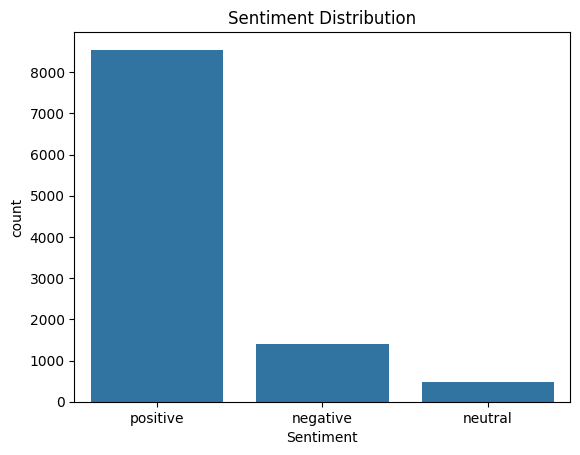

In [17]:
sns.countplot(data=df, x='Sentiment')
plt.title('Sentiment Distribution')
plt.show()

In [18]:
def preprocess(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    return tokens

df['Preprocessed Review'] = df['Review'].apply(preprocess)

In [19]:
df['Preprocessed Review']

,Preprocessed Review
0,[super]
1,[awesome]
2,[fair]
3,"[useless, product]"
4,[fair]
...,...
11031,[awesome]
11032,[wonderful]
11033,"[really, nice]"
11034,[super]


In [20]:
from gensim.models import Word2Vec

# Train the Word2Vec model
w2v_model = Word2Vec(sentences=df['Preprocessed Review'], vector_size=100, window=5, min_count=1, workers=4)

# Save the model
w2v_model.save("word2vec_sentiment_model.model")

In [29]:
from tensorflow.keras.utils import to_categorical

# Function to convert reviews into sequences of word embeddings
def get_review_embeddings(review_tokens, w2v_model):
    embeddings = []
    for word in review_tokens:
        if word in w2v_model.wv:
            embeddings.append(w2v_model.wv[word])
    return embeddings

# Convert reviews to sequences of word embeddings
X = [get_review_embeddings(tokens, w2v_model) for tokens in df['Preprocessed Review']]

# Pad sequences to ensure uniform input length
X = pad_sequences(X, padding='post', dtype='float32')

# Sentiment labels (assuming binary classification: 0 = negative, 1 = positive)
y = df['Sentiment'].map({'negative':0, 'neutral':1, 'positive':2}).values
y = to_categorical(y, num_classes=3)

# Check for NaN values in 'y' and handle them (e.g., drop rows with NaN)
nan_indices = np.any(np.isnan(y), axis=1)
X = X[~nan_indices]  # Remove corresponding rows from X
y = y[~nan_indices]  # Remove NaN values from y

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential()

# LSTM layer
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(128, activation='relu'))

# Dropout layer to prevent overfitting
model.add(Dropout(0.2))

# Output layer
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001, weight_decay = 1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=8, batch_size=64, validation_data=(X_test, y_test), verbose=2)

Epoch 1/8
131/131 - 68s - 516ms/step - accuracy: 0.8164 - loss: 0.6155 - val_accuracy: 0.8139 - val_loss: 0.5812
Epoch 2/8
131/131 - 8s - 63ms/step - accuracy: 0.8269 - loss: 0.5517 - val_accuracy: 0.8168 - val_loss: 0.5813
Epoch 3/8
131/131 - 8s - 58ms/step - accuracy: 0.8375 - loss: 0.5130 - val_accuracy: 0.8484 - val_loss: 0.4788
Epoch 4/8
131/131 - 7s - 55ms/step - accuracy: 0.8641 - loss: 0.4445 - val_accuracy: 0.8580 - val_loss: 0.4523
Epoch 5/8
131/131 - 9s - 66ms/step - accuracy: 0.8872 - loss: 0.3936 - val_accuracy: 0.8691 - val_loss: 0.4431
Epoch 6/8
131/131 - 11s - 82ms/step - accuracy: 0.8940 - loss: 0.3911 - val_accuracy: 0.8820 - val_loss: 0.4142
Epoch 7/8
131/131 - 11s - 82ms/step - accuracy: 0.8998 - loss: 0.3681 - val_accuracy: 0.8882 - val_loss: 0.3873
Epoch 8/8
131/131 - 11s - 86ms/step - accuracy: 0.9008 - loss: 0.3615 - val_accuracy: 0.8897 - val_loss: 0.3866


In [44]:
# Evaluate the model
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Accuracy
accuracy = accuracy_score(y_test_labels, y_pred)
print(f'Accuracy: {accuracy:.4f}')
report = classification_report(y_test_labels, y_pred)
print(report)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Accuracy: 0.8897
              precision    recall  f1-score   support

           0       0.80      0.65      0.72       279
           1       0.00      0.00      0.00       109
           2       0.90      0.99      0.94      1697

    accuracy                           0.89      2085
   macro avg       0.57      0.55      0.55      2085
weighted avg       0.84      0.89      0.86      2085



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
